# Building alternative pipeline

* Prepare Hough transform based only on wire information (= energy, time, radial distance)
* Build predictions based on Hough, local information, and local information of left/right neighbors


In [1]:
%run visualizations.ipynb
import sys
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from hits import AllHits
hits = AllHits('../data/signal.root')

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model

In [4]:
def get_circle(x_coeff, y_coeff, intercept):
    return x_coeff/2, y_coeff/2, np.sqrt(4*intercept + x_coeff**2 + y_coeff**2)/2

In [5]:
def inside_target(model, X, y):
    a, b, r = get_circle(model.coef_[0][0], model.coef_[0][1], model.intercept_)
    return abs(np.sqrt(a**2 + b**2) - r) < 10

In [6]:
# each hit point scored by how many times it is useful in completeing a ciruclar fit.  RANSAC "voting"
# random 

Event 2
Fit:31.0984459789
RANSAC Fit:31.0984459789

Fit:27.1842951748
RANSAC Fit:27.1842951748



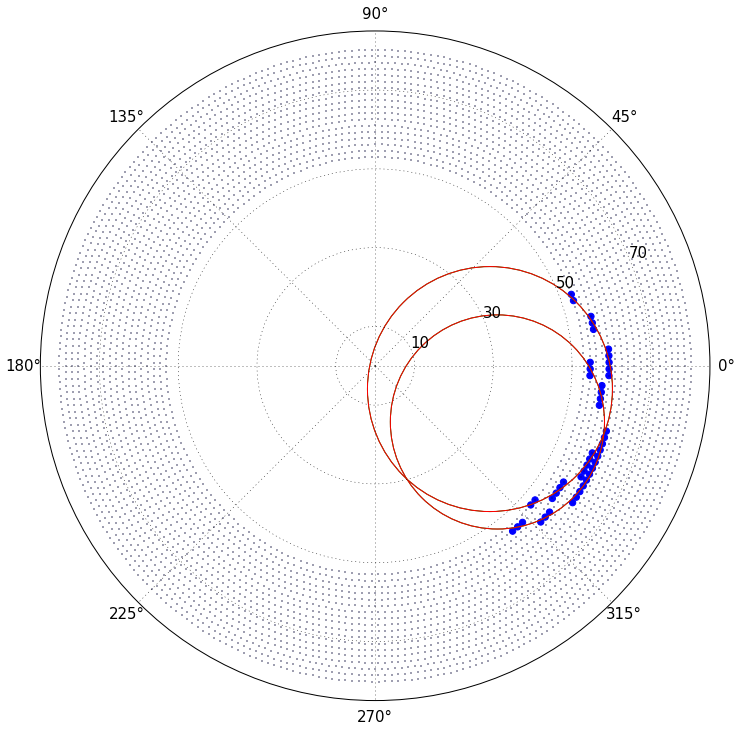

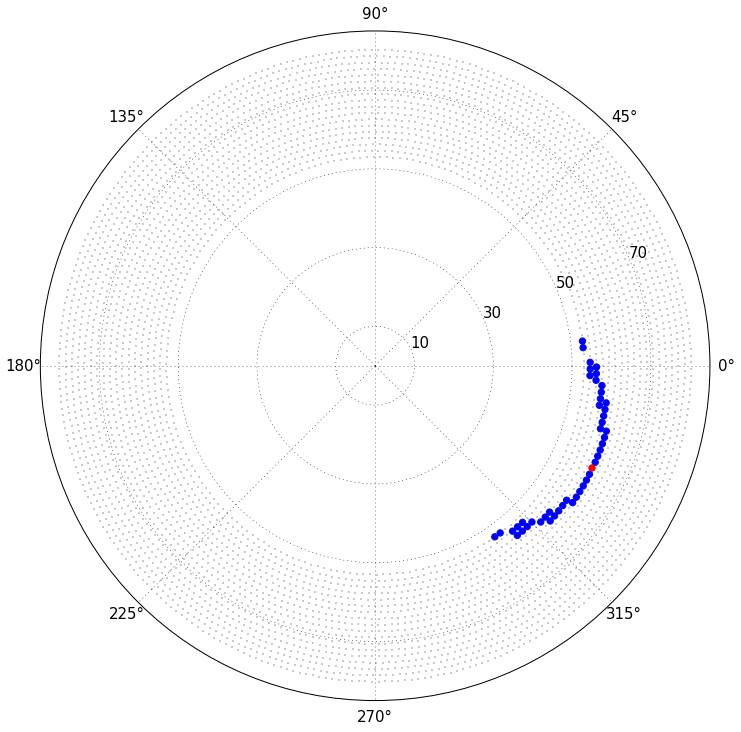

In [23]:
wire_x, wire_y = hits.cydet.get_points_xs_and_ys()

for evt in range(2,3):
    print "Event " + str(evt)
    
    # Get the even and odd signals
    even_sig, odd_sig = hits.get_hit_wires_even_odd(evt)
    # Skip if too few points
    if (even_sig.shape[0] < 13) or (odd_sig.shape[0] < 13):
        print "Skipped"
        continue
        
    # Initialze parameters
    x1, y1, r1 = np.zeros(2), np.zeros(2), np.zeros(2)
    x2, y2, r2 = np.zeros(2), np.zeros(2), np.zeros(2)

    for pol, sig_hits in enumerate([even_sig, odd_sig]):
        
        # Add noise
        #noise_hits = np.random.random_integers(hits.cydet.n_points-1, size=100)
        #noise_hits = np.unique(noise_hits)
        #noise_hits = np.setdiff1d(noise_hits, sig_hits)
        #all_hits = np.append(sig_hits, noise_hits)
        all_hits = sig_hits
        
        # Get the points to fit
        fit_x, fit_y = wire_x[all_hits], wire_y[all_hits]
        # Linearize the equation
        fit_xy = np.vstack([fit_x,fit_y]).T
        fit_z = np.square(fit_x) + np.square(fit_y)

        # Fit line using all data
        model = linear_model.LinearRegression()
        model.fit(fit_xy, fit_z)

        # Robustly fit linear model with RANSAC algorithm
        model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),  
                                                    is_model_valid=inside_target,
                                                   max_trials=1000)
        model_ransac.fit(fit_xy, fit_z)
        # Check inliers, outliers
        inlier_mask = all_hits[model_ransac.inlier_mask_]
        outlier_mask = all_hits[np.logical_not(model_ransac.inlier_mask_)]

        # Plot the output
        labels = np.zeros(hits.cydet.n_points)
        labels[inlier_mask] = 1
        labels[outlier_mask] = 2
        plot_output(labels, hits.cydet)
        
        # Get the regular fit
        x1[pol], y1[pol], r1[pol] = get_circle(model.coef_[0], model.coef_[1] , model.intercept_)
        plot_add_circle(x1[pol], y1[pol], r1[pol])
        print "Fit:" + str(r1[pol])
        
        # Get the RANSAC fit
        x2[pol], y2[pol], r2[pol] = get_circle(model_ransac.estimator_.coef_[0][0], 
                         model_ransac.estimator_.coef_[0][1] , model_ransac.estimator_.intercept_)
        plot_add_circle(x2[pol], y2[pol], r2[pol], color="red")
        print "RANSAC Fit:" + str(r2[pol]) + "\n"
        
        # Make sure we're plotting all points
        assert len(inlier_mask) + len(outlier_mask) == len(all_hits),\
            "{} {}".format(len(inlier_mask) + len(outlier_mask), len(all_hits))
        plt.savefig("/home/elg112/COMET/Presentations_Papers/group_meetings/images/global_z_0.png", bbox_inches="tight")
    show()    
    
    # Rotate the outputs together
    phi_even = np.arctan(y1[0]/x1[0])
    phi_odd  = np.arctan(y1[1]/x1[1])
    d_phi = phi_odd - phi_even
    plot_output(hits.get_hit_types(evt), hits.cydet, rotate_even=d_phi)
    plt.savefig("/home/elg112/COMET/Presentations_Papers/group_meetings/images/global_z_1.png", bbox_inches="tight")
    show()

Estimated coefficients (true, normal, RANSAC):
(array(82.1903908407869), array([ 54.17236387]), array([[ 82.08533159]]))


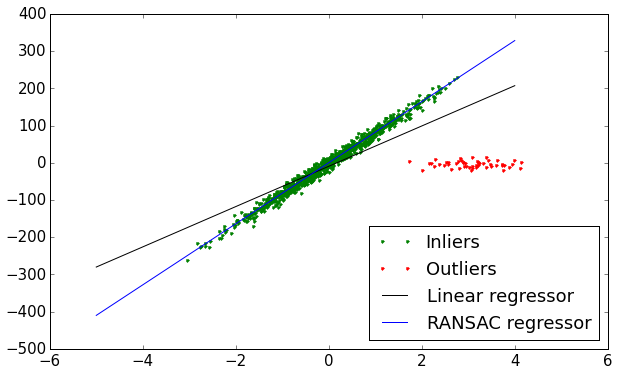

In [17]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn import linear_model, datasets
figsize(10,6)

n_samples = 1000
n_outliers = 50


X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
model = linear_model.LinearRegression()
model.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac.fit(X, y)
inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(-5, 5)
line_y = model.predict(line_X[:, np.newaxis])
line_y_ransac = model_ransac.predict(line_X[:, np.newaxis])

# Compare estimated coefficients
print("Estimated coefficients (true, normal, RANSAC):")
print(coef, model.coef_, model_ransac.estimator_.coef_)

plt.plot(X[inlier_mask], y[inlier_mask], '.g', label='Inliers')
plt.plot(X[outlier_mask], y[outlier_mask], '.r', label='Outliers')
plt.plot(line_X, line_y, '-k', label='Linear regressor')
plt.plot(line_X, line_y_ransac, '-b', label='RANSAC regressor')
plt.legend(loc='lower right')
plt.savefig("/home/elg112/COMET/Presentations_Papers/group_meetings/images/RANSAC_line.png", bbox_inches="tight")
plt.show()